In [47]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import random
from numba import jit
import time
import dask 
from dask import delayed
from collections import deque
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import pandas as pd

In [48]:
@jit(nopython=True)
def _compute_gradient(pos_x, pos_y, u, dx, dy, step = 1):
    
    x, y = pos_x, pos_y 

    # Compute central difference gradient
    if 1 <= x < u.shape[0] - 1 and 1 <= y < u.shape[1] - 1: # boundary rejection

        grad_x = (u[x+step, y] - u[x-step, y]) / (2 * dx) # x grad
        grad_y = (u[x, y+step] - u[x, y-step]) / (2 * dy) # y grad
    
    else:
        grad_x, grad_y = 0, 0 
    
    return grad_x, grad_y

In [49]:
class Cell():
    def __init__(self, pos_x, pos_y):
        self.pos_x = int(pos_x)
        self.pos_y = int(pos_y)
        self.pos_history = deque()
        self.pos_history.append([0,self.pos_x,self.pos_y])
    
    def update_pos(self, grid_size, step = 3):
        self.pos_x = np.clip(self.pos_x + np.random.randint(-step, step), 0, grid_size - 1)
        self.pos_y = np.clip(self.pos_y + np.random.randint(-step, step), 0, grid_size - 1)


   # @jit(nopython = True)
    def compute_gradient(self, u, dx, dy, step = 3):
        
        grad_x, grad_y = _compute_gradient(self.pos_x, self.pos_y, u, dx, dy, step)
        return grad_x, grad_y
    
    #@jit(nopython = True)
    def update_pos_grad(self, u, dx, dy, sensitivity, time_curr, dt, step=1,):
        
        grad_x, grad_y = self.compute_gradient(u, dx, dy)

        rand_x = random.randint(-step, step)
        rand_y = random.randint(-step, step)
        # Scale gradient to influence movement
        move_x = rand_x + grad_x * sensitivity
        move_y = rand_y + grad_y * sensitivity

        # Update cell position with stochastic movement, ensuring it stays within bounds
        self.pos_x = np.clip(self.pos_x + int(move_x), 0, u.shape[0] - 1)
        self.pos_y = np.clip(self.pos_y + int(move_y), 0, u.shape[1] - 1)

        self.pos_history.append([time_curr+dt, self.pos_x, self.pos_y])

    def get_position_history(self,type="list"):
        if type=="list":
            return list(self.pos_history)
        elif type == "df":
            df = pd.DataFrame ( list(self.pos_history), columns = ["time_step", "pos_x", "pos_y"]) 
            return df

In [50]:
alpha = 400
length = 400
sim_time = 5
nodes = 250
num_cells= 8

dx = length / nodes
dy= length / nodes


dt = min(dx**2 / (4*alpha), dy**2 / (4/alpha))

t_nodes = int(sim_time/dt)

u = np.zeros((nodes, nodes))


array_len = len(u)

max_temp = 100

u[:,-1:-10] = max_temp
#u[:,int(nodes*0.75):]= max_temp
u[0:50,:] = max_temp
#u[ int(len(u)/2): int(len(u)/2)] = 100

center_x, center_y = nodes // 2, nodes // 2
radius = 15  # Radius of high temperature region

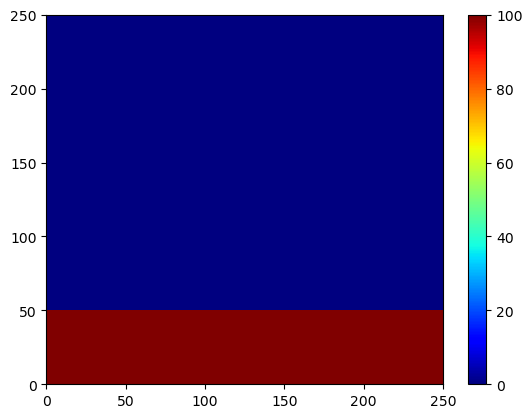

In [51]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(u, cmap = plt.cm.jet, vmin=0, vmax=100)
plt.colorbar(pcm, ax=axis)


In [52]:
cells = [Cell( int(nodes/ 2),int( nodes / 2)) for _ in range(num_cells)]
counter = 0 
cellMarker = []

@jit(nopython=True)
def calc_grad_np(u):
    w = u.copy()
    w[1:-1, 1:-1] = (
        u[1:-1, 1:-1]
        + alpha * dt * (
            (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2
            + (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2
        )
    )
    return w

In [53]:
@delayed
def update_cell(c, u, dx, dy, counter, dt):
    c.update_pos_grad(u, dx, dy, 0.5, counter, dt)
    u[c.pos_x, c.pos_y] =  u[c.pos_x, c.pos_y] / 10
    return c

In [ ]:
start = time.time()

while counter < sim_time : # O(t)

    w = u.copy()
    if cellMarker:
        for mark in cellMarker: # O(n)
            mark.remove()

    u = calc_grad_np(u)            
    
    tasks = [ delayed (update_cell)(c, u, dx, dy, counter, dt) for c in cells ]    
    results = dask.compute(*tasks)

  #  print("t: {:.3f} [s], Concentration {:.2f} %".format(counter, np.average(u)))

    pcm.set_array(u)
    axis.set_title("Distribution at t: {:.3f} [s].".format(counter))

    cellMarker = [axis.plot(cell.pos_y, cell.pos_x, 'wo', markersize=8)[0] for cell in cells]  

 
    #plt.pause(0.01)
    counter += dt
    
end = time.time()

FINAL = end - start

print(f'Total Execution Time: {FINAL}')

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x137c145e0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/eff/lib/python3.12/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
test_cell1 = cells[0].get_position_history(type="df")

In [ ]:
test_cell1

,time_step,pos_x,pos_y
0,0.000000,300,300
1,0.006806,299,301
2,0.013611,299,302
3,0.020417,300,301
4,0.027222,299,302
...,...,...,...
1466,9.976944,350,308
1467,9.983750,349,309
1468,9.990556,349,309
1469,9.997361,349,308


In [ ]:
cell_0_pos_history = np.array(cells[0].get_position_history())
cell_1_pos_history = np.array(cells[1].get_position_history())
cell_2_pos_history = np.array(cells[2].get_position_history())
cell_3_pos_history = np.array(cells[3].get_position_history())


In [ ]:
def plot_cell_history(cell_history):
    time_steps = cell_history [:,0]
    x_pos = cell_history [:,1]
    y_pos = cell_history [:,2]

    points = np.array([x_pos, y_pos]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.gca().add_collection(lc)
    plt.plot(x_pos, y_pos, color='black', alpha=0.1)
    # Annotate start and end
    plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)
    plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)

    plt.colorbar(lc, label='Time Step')
    plt.title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:

def plot_history_2(position_history, ax=None, color=None, cmap='viridis', label='Cell Path'):
    """
    Plots a cell's movement trajectory on a given axis with a color gradient based on time steps.

    Parameters:
    - position_history (np.ndarray): Array of shape (n, 3) where each row is [time_step, x, y].
    - ax (matplotlib.axes._axes.Axes, optional): Axis to plot on. If None, a new figure and axis are created.
    - cmap (str, optional): Colormap for the trajectory.
    - label (str, optional): Label for the cell trajectory.
    
    Returns:
    - fig (matplotlib.figure.Figure): The figure object.
    - ax (matplotlib.axes._axes.Axes): The axes object.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Extract time steps, x positions, and y positions
    time_steps = position_history[:, 0]
    x_positions = position_history[:, 1]
    y_positions = position_history[:, 2]

    # Create segments for LineCollection
    points = np.array([x_positions, y_positions]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.plot(x_positions, y_positions, color=color, alpha=0.3)  # Base path with markers for reference

    # Annotate start and end
    ax.scatter(x_positions[0], y_positions[0], label='Start', zorder=5)
    ax.scatter(x_positions[-1], y_positions[-1], label='End', zorder=5)

    ax.set_title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    ax.legend()

    return fig, ax, lc

/var/folders/_4/kt858wtj2111y2396_n7rtsm0000gn/T/ipykernel_92379/2067441439.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('hsv', num_trajectories)


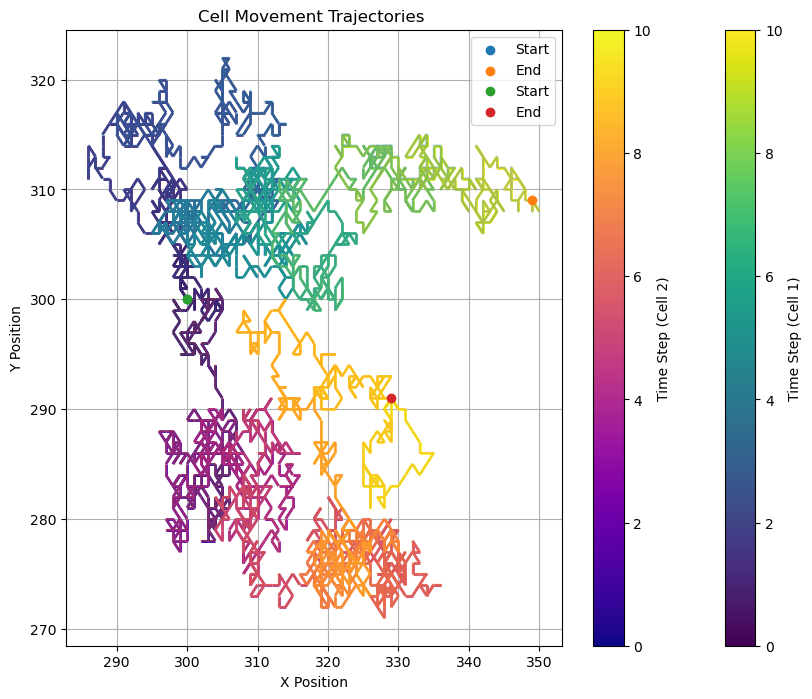

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

trajectories = [cell_0_pos_history, cell_1_pos_history]

num_trajectories = len(trajectories)
colors = cm.get_cmap('hsv', num_trajectories)


colormaps = ['viridis', 'plasma']

for idx, traj in enumerate(trajectories):
    fig, ax, lc = plot_history_2(traj, ax=ax, cmap=colormaps[idx], label=f'Cell {idx + 1}')
    cbar = plt.colorbar(lc, ax=ax, label=f'Time Step (Cell {idx + 1})')
    cbar.set_label(f'Time Step (Cell {idx + 1})')
    
ax.legend()
plt.title("Cell Movement Trajectories ")
plt.show()

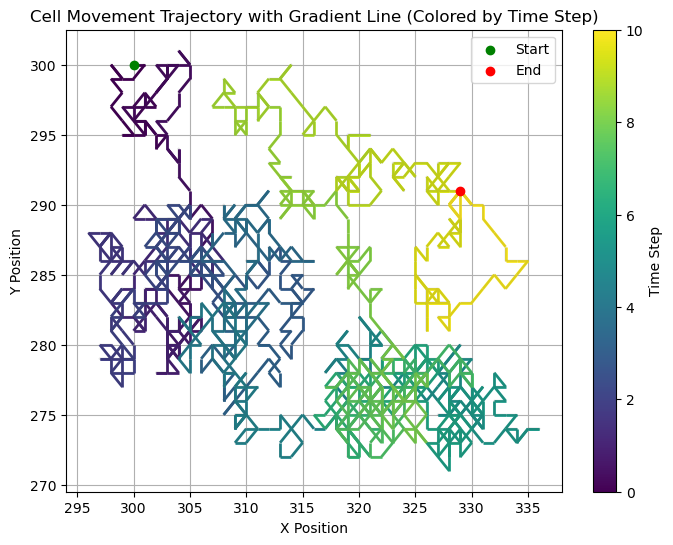

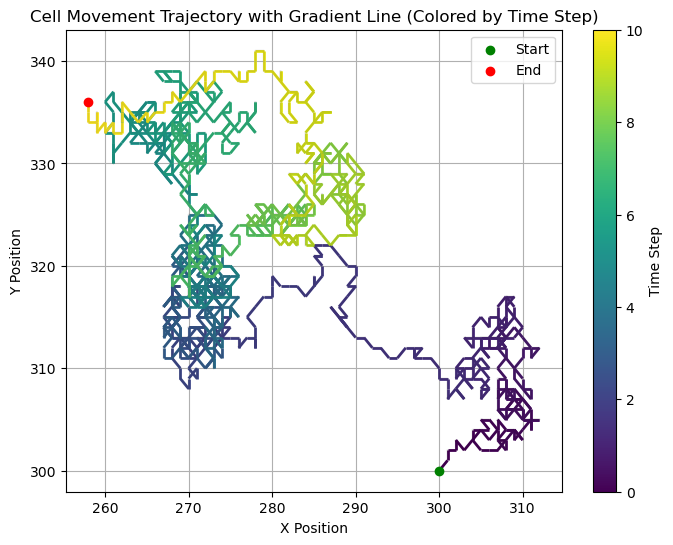

In [ ]:
plot_cell_history(cell_1_pos_history)
plot_cell_history(cell_2_pos_history)

In [ ]:
time_steps = cell_0_pos_history [:,0]
x_pos = cell_0_pos_history [:,1]
y_pos = cell_0_pos_history [:,2]

In [ ]:
from matplotlib.collections import LineCollection

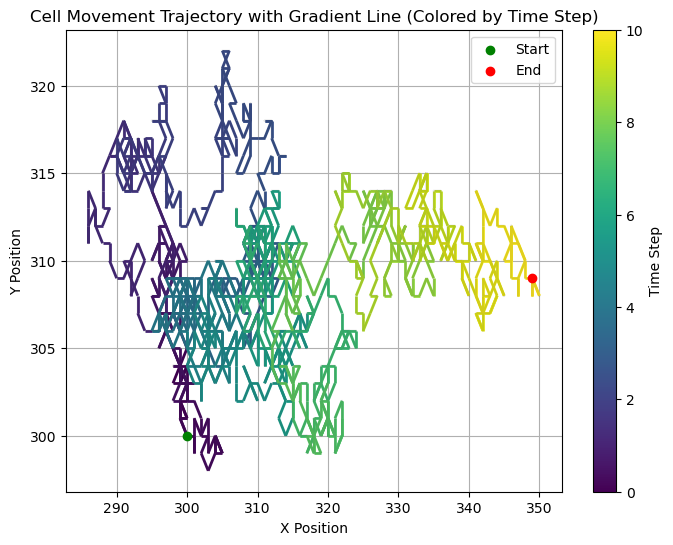

In [ ]:
points = np.array([x_pos, y_pos]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with color mapping
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time_steps.min(), time_steps.max()))
lc.set_array(time_steps)
lc.set_linewidth(2)

# Plot
plt.figure(figsize=(8, 6))
plt.gca().add_collection(lc)
plt.plot(x_pos, y_pos, color='black', alpha=0.1)
# Annotate start and end
plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)
plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)

plt.colorbar(lc, label='Time Step')
plt.title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.legend()
plt.show()

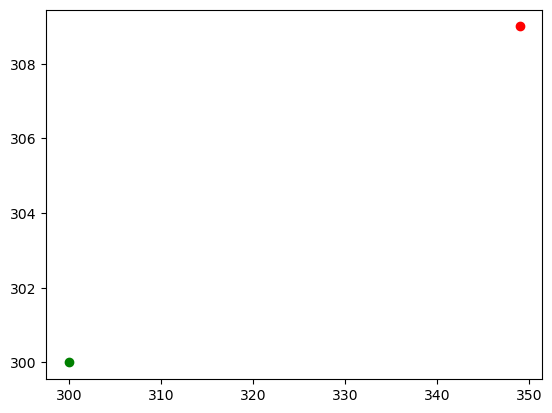

In [ ]:
plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)

plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)